<a href="https://colab.research.google.com/github/georgerieh/spotify-million-dataset/blob/main/Spotify_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from tqdm import tqdm
import torch
from scipy.sparse import csr_matrix as sp_csr_matrix, load_npz, save_npz
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow.parquet as pq

# Plan

## Part 1. Build simple CF
## Part 2. EDA
## Part 3. Modification of CF
## Part 4. Evaluation


## Part 0
Load the dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!unzip -q '/content/drive/MyDrive/spotify_million_playlist_dataset.zip' -d 'spotify_million_playlist_dataset'

In [2]:
import json
import glob
import csv
import hashlib
import re
import cudf
from tqdm import tqdm

def stable_hash(s):
    # Shorten to 16 chars for a 64-bit int to save space
    return int(hashlib.md5(s.encode('utf-8')).hexdigest()[:16], 16)

def process_and_split_data():
    files = glob.glob("spotify_million_playlist_dataset/data/*.json")
    seen_songs = set()

    # Keep Metadata on Drive, but keep the heavy Interactions on Local VM first
    with open('/content/drive/MyDrive/spotify-challenge/song_library.csv', "w", newline="") as f_song, \
         open('/content/drive/MyDrive/spotify-challenge/playlist_library.csv', "w", newline="") as f_play, open('/content/drive/MyDrive/spotify-challenge/playlist_song.csv', "w", newline="") as f_ps:

        song_writer = csv.writer(f_song)
        play_writer = csv.writer(f_play)

        song_writer.writerow(["track_hash", "name", "artist", "album", "dur"])
        play_writer.writerow(["pid", "p_name", "is_shared", "n_tracks", "n_followers", 'n_albums'])

        all_interactions = []
        file_count = 0
        chunk_size = 50 # Write to parquet every 50 JSON files

        for file_name in tqdm(files):
            with open(file_name, "r") as jf:
                data = json.load(jf)
                for playlist in data["playlists"]:
                    if playlist['num_tracks'] >=10 and playlist['num_tracks']<=250: #check eda step
                      pid = playlist["pid"]
                      play_writer.writerow([
                            pid, playlist['name'], json.loads(playlist['collaborative']),
                            playlist['num_tracks'], playlist['num_followers'], playlist['num_albums']
                        ])

                      for track in playlist["tracks"]:
                          # Faster string cleaning than regex
                          clean_name = (track['track_name'] + track['album_name']).lower()
                          clean_str = "".join(filter(str.isalnum, clean_name))
                          track_hash = stable_hash(clean_str)
                          all_interactions.append({'pid': pid, 'tid': track_hash, 'pos': track['pos'], 'added': 1})

                          if track_hash not in seen_songs:
                              song_writer.writerow([
                                  track_hash, track['track_name'], track['artist_name'],
                                  track['album_name'], track['duration_ms']
                              ])
                              seen_songs.add(track_hash)

            file_count += 1
            if file_count % chunk_size == 0:
                df_chunk = cudf.DataFrame(all_interactions)
                df_chunk.to_parquet(f'/content/interactions_chunk_{file_count}.parquet', compression='snappy')
                all_interactions = []
        if all_interactions:
            df_chunk = cudf.DataFrame(all_interactions)
            df_chunk.to_parquet(f'/content/interactions_chunk_final.parquet', compression='snappy')

    # Final Step: Copy all chunks to Drive
    !mkdir -p /content/drive/MyDrive/spotify-challenge/interactions_parquet/
    !cp /content/*.parquet /content/drive/MyDrive/spotify-challenge/interactions_parquet/
process_and_split_data()





100%|██████████| 1000/1000 [11:55<00:00,  1.40it/s]


In [4]:
!pip install fastparquet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 35.7 MB/s eta 0:00:00


In [5]:
target_schema = {
    'pid': 'int32',
    'tid': 'int64',
    'pos': 'int16'
}
import glob
files = glob.glob('/content/drive/MyDrive/spotify-challenge/interactions_parquet/*.parquet')
list_of_gdfs = []
for f in files:
    temp_gdf = cudf.read_parquet(f)
    # Force the columns to match the target schema
    for col, dtype in target_schema.items():
        if col in temp_gdf.columns:
            temp_gdf[col] = temp_gdf[col].astype(dtype)
    list_of_gdfs.append(temp_gdf)

# Combine them safely
gdf = cudf.concat(list_of_gdfs)

# Define the path
output_path = '/content/drive/MyDrive/spotify-challenge/interactions_master.parquet'

# 1. Determine how many rows to handle at once (e.g., 5 million)
chunk_size = 5_000_000
total_rows = len(gdf)

print(f"Total rows to save: {total_rows:,}")

# 2. Use a loop to write the file in chunks
# We convert each chunk to a Pandas DataFrame (CPU) to free up GPU memory
for i in range(0, total_rows, chunk_size):
    start = i
    end = min(i + chunk_size, total_rows)

    # Slice the GPU dataframe and move ONLY that slice to CPU
    chunk_cpu = gdf.iloc[start:end].to_pandas()

    # For the first chunk, create the file. For others, append.
    if i == 0:
        chunk_cpu.to_parquet(output_path, engine='fastparquet', index=False, compression='snappy')
    else:
        # Note: fastparquet engine supports appending to the same file structure
        chunk_cpu.to_parquet(output_path, engine='fastparquet', index=False, compression='snappy', append=True)



Total rows to save: 66,084,861


In [6]:
import cudf

# 1. Load the master interaction file
gdf = cudf.read_parquet('/content/drive/MyDrive/spotify-challenge/interactions_master.parquet')

# 2. Group by Playlist ID (pid) and count track IDs (tid)
# This calculates the size of every single playlist in the dataset
playlist_sizes = gdf.groupby('pid')['pos'].max()


max_songs = playlist_sizes.max()
min_songs = playlist_sizes.min()
avg_songs = playlist_sizes.mean()
print(f"Maximum songs in a single playlist: {max_songs}")
print(f"Minimum songs in a single playlist: {min_songs}")
print(f"Average songs per playlist: {avg_songs:.2f}")

Maximum songs in a single playlist: 249
Minimum songs in a single playlist: 9
Average songs per playlist: 67.55


Distribution of number of playlists bty numver of songs in it (previous run)

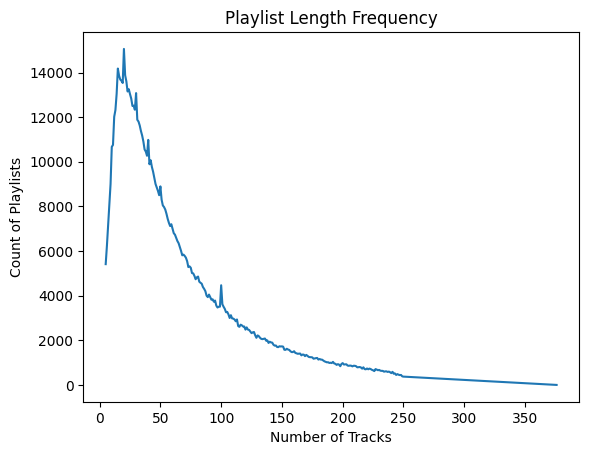

<Axes: xlabel='is_shared'>

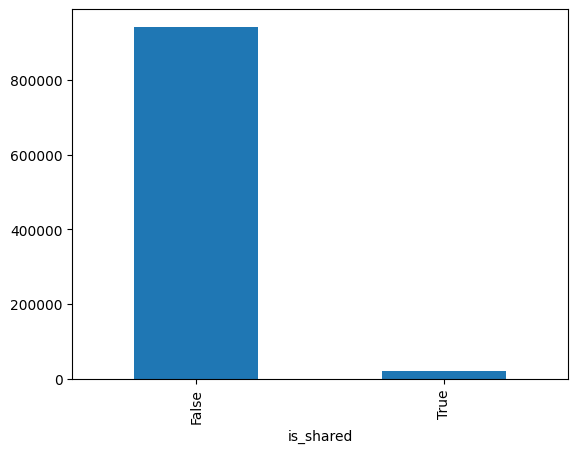

In [12]:
playlist = cudf.read_csv('/content/drive/MyDrive/spotify-challenge/playlist_library.csv')

playlist['is_shared'].value_counts().to_pandas().plot(kind='bar')


at first, I was going to select only 'shared' playlists, as they are more in the state of 'done' than private ones. but since the absolute majority of playlists are private, I will not exclude them from the study

In [19]:
playlist_map = {}
song_map = {}

next_playlist_idx = 0
next_song_idx = 0
parquet_file = pq.ParquetFile("/content/drive/MyDrive/spotify-challenge/interactions_master.parquet")
for i in tqdm(range(parquet_file.num_row_groups), desc="Processing Row Groups"):
    chunk = parquet_file.read_row_group(i).to_pandas()
    for row in chunk.itertuples():
        pid_hash = int(row.pid)
        sid_hash = int(row.tid)
        if pid_hash not in playlist_map:
            playlist_map[int(pid_hash)] = next_playlist_idx
            next_playlist_idx += 1
        if sid_hash not in song_map:
            song_map[int(sid_hash)] = next_song_idx
            next_song_idx += 1

with open('/content/drive/MyDrive/spotify-challenge/playlist_map.json', 'w') as pl, open('/content/drive/MyDrive/spotify-challenge/song_map.json', 'w') as so:
  json.dump(playlist_map, pl)
  json.dump(song_map, so)

Processing Row Groups: 100%|██████████| 14/14 [01:37<00:00,  6.96s/it]


In [22]:
from scipy.sparse import coo_matrix, save_npz, load_npz

rows = []
cols = []
data_vals = []

arquet_file = pq.ParquetFile("/content/drive/MyDrive/spotify-challenge/interactions_master.parquet")
for i in tqdm(range(parquet_file.num_row_groups), desc="Processing Row Groups"):
    chunk = parquet_file.read_row_group(i).to_pandas()
    for row in chunk.itertuples():
        pid_idx = playlist_map[int(row.pid)]
        sid_idx = song_map[int(row.tid)]

        rows.append(pid_idx)
        cols.append(sid_idx)
        data_vals.append(1)  # binary interaction

interaction_matrix = coo_matrix(
    (data_vals, (rows, cols)),
    shape=(len(playlist_map), len(song_map))
)

save_npz('/content/drive/MyDrive/spotify-challenge/interaction.npz', interaction_matrix)
del interaction_matrix


Processing Row Groups: 100%|██████████| 14/14 [01:47<00:00,  7.68s/it]


In [3]:
interaction_matrix = load_npz('/content/drive/MyDrive/spotify-challenge/interaction.npz')
interaction_matrix = interaction_matrix.tocsr()
save_npz('/content/drive/MyDrive/spotify-challenge/interaction_csr.npz', interaction_matrix)
del interaction_matrix


In [4]:
all_recommendations = {}  # key = playlist index, value = list of top-n songs

def save_recommendations(playlist_idx, recommended_songs):
    all_recommendations[playlist_idx] = recommended_songs


In [5]:
# import cupy as cp
from cupyx.scipy.sparse import csr_matrix as cp_csr_matrix
def csr_to_torch_sparse(csr_matrix):
    coo = csr_matrix.tocoo()  # must be COO
    if coo.data.size == 0:
        # empty matrix → return a 0-valued sparse tensor
        indices = torch.zeros((2,0), dtype=torch.long)
        values  = torch.zeros((0,), dtype=torch.float32)
    else:
        indices = torch.tensor([coo.row, coo.col], dtype=torch.long)
        values  = torch.tensor(coo.data, dtype=torch.float32)  # must be float
    shape = coo.shape
    return torch.sparse_coo_tensor(indices, values, size=shape)

def compute_topk_similarity_gpu(
    sparse_x_batch_cpu: sp_csr_matrix,
    csr_matrix_all_cupy: cp_csr_matrix,
    top_k: int = 5,
    zero_self_similarity: bool = False,
    batch_offset: int = 0,
):
    # Convert CPU batch to GPU (CuPy)
    sparse_x_batch_gpu = cp_csr_matrix(sparse_x_batch_cpu)

    # Calculate L2 norms for normalization
    # Example: If a row is [3, 0, 4], power(2) is [9, 0, 16], sum is 25, sqrt is 5.
    all_norms = cp.sqrt(csr_matrix_all_cupy.power(2).sum(axis=1)).ravel()
    batch_norms = cp.sqrt(sparse_x_batch_gpu.power(2).sum(axis=1)).ravel()

    # Compute sparse dot product (Batch Matrix Multiplication)
    # ====== #
    # sparse_x_batch (2 rows) = [[1, 0], [0, 1]]
    # csr_matrix_all (3 rows) = [[1, 1], [1, 0], [0, 1]]
    # sim = batch @ all.T
    # sim result shape: (2, 3) -> Matrix of dot products
    # sim = [[1, 1, 0],
    #        [1, 0, 1]]
    # ====== #
    sim = sparse_x_batch_gpu @ csr_matrix_all_cupy.T

    if cp.sparse.issparse(sim):
        sim = sim.toarray().astype('f')

    # Normalize similarity scores
    # ====== #
    # batch_norms = [1.0, 1.0] (shape 2,)
    # all_norms = [1.41, 1.0, 1.0] (shape 3,)
    # batch_norms[:, None] transforms to (2, 1) column
    # all_norms[None, :] transforms to (1, 3) row
    # Multiplying them creates a (2, 3) denominator matrix:
    # [[1.41, 1.0, 1.0],
    #  [1.41, 1.0, 1.0]]
    # sim = sim / (denominator + 1e-8)
    # ====== #
    sim = sim / (batch_norms[:, None] * all_norms[None, :] + 1e-8)

    # Optional: remove self-similarity
    if zero_self_similarity:
        rows_in_batch = sparse_x_batch_gpu.shape[0]
        for i in tqdm(range(rows_in_batch)):
            global_idx = batch_offset + i
            if global_idx < csr_matrix_all_cupy.shape[0]:
                # Sets the diagonal element (the item vs itself) to 0
                sim[i, global_idx] = 0.0

    # Top-k selection (GPU)
    # ====== #
    # sim = [[0.7, 1.0, 0.2],
    #        [0.1, 0.5, 0.9]]
    # cp.argsort(sim, axis=1) ->
     #[[2, 0, 1],
     #[0, 1, 2]] (indices of values low to high)
    # [:, ::-1] reverses it    -> [[1, 0, 2], [2, 1, 0]] (indices of values high to low)
    # [:, :top_k] (top_k=2)    -> [[1, 0], [2, 1]]
    # ====== #
    topk_idx = cp.argsort(sim, axis=1)[:, ::-1][:, :top_k]

    # Use take_along_axis to get the corresponding values
    # ====== #
    # From sim, pick values at indices [[1, 0], [2, 1]]
    # topk_vals = [[1.0, 0.7], [0.9, 0.5]]
    # ====== #
    topk_vals = cp.take_along_axis(sim, topk_idx, axis=1)

    return topk_idx.get(), topk_vals.get()
from google.colab import runtime
runtime.unassign()

In [ ]:
import numpy as np
import cupy as cp
from cupy.sparse import csr_matrix as cp_csr_matrix
from scipy.sparse import csr_matrix as sp_csr_matrix

# Convert the interaction_matrix to CuPy's sparse matrix format once
# This will be used for GPU computations.
# The original scipy.sparse.csr_matrix is still named 'interaction_matrix'
# and will be used by functions like gather_candidate_songs and score_candidate_songs
# that are not yet cupy-enabled.
interaction_matrix = load_npz('/content/drive/MyDrive/spotify-challenge/interaction_csr.npz')
interaction_matrix_gpu = cp_csr_matrix(interaction_matrix.astype('f'))
def score_candidate_songs(candidate_songs_indices, top_similar_playlist_indices, top_similar_scores, interaction_matrix):
    scores = {}
    for song_idx in candidate_songs_indices:
        score = 0.0
        for i, sim_playlist_idx in enumerate(top_similar_playlist_indices):
            # Check if the song is in the similar playlist
            if interaction_matrix[sim_playlist_idx, song_idx] > 0:
                score += top_similar_scores[i]  # Add the similarity score
        scores[song_idx] = score
    return scores
# Redefine the compute_topk_similarity_gpu function to use CuPy

import cupy as cp
from cupyx.scipy.sparse import csr_matrix as cp_csr_matrix
import numpy as np

# 1. SETUP
interaction_matrix = load_npz('interaction_csr.npz').astype('f')
interaction_matrix_gpu = cp_csr_matrix(interaction_matrix)

batch_size = 512
top_k = 5
top_n = 500  # Based on your goal of 500 songs

for batch_start in tqdm(range(0, interaction_matrix_gpu.shape[0], batch_size)):
    batch_end = min(batch_start + batch_size, interaction_matrix_gpu.shape[0])
    target_batch_cpu = interaction_matrix[batch_start:batch_end, :]

    # [DATA MOVE] CPU RAM -> GPU VRAM
    # Shape: (batch_size, num_songs) -> [████████] (Sparse)
    target_batch_gpu = cp_csr_matrix(target_batch_cpu.astype('f'))

    # [SIMILARITY] Finds Top 5 similar playlists for each of the 50 playlists in the batch
    # Output Indices: (50, 5) -> [[P1, P2, P3, P4, P5], ...]
    # Output Scores:  (50, 5) -> [[.9, .8, .7, .6, .5], ...]
    topk_indices, topk_scores = compute_topk_similarity_gpu(
        target_batch_cpu,
        interaction_matrix_gpu,
        top_k=5,
        batch_offset=batch_start
    )

    # [FLATTEN] (50, 5) -> (250,) | 1D list of all neighbor IDs to grab them at once
    neighbor_indices = cp.array(topk_indices.ravel())

    # [GATHER] Extraction from the main 1M x 2M matrix
    # (250,) indices + (1M, 2M) Matrix -> (250, 2M) Neighbor Matrix
    # Visual: [Batch1_Neighbors]
    #         [Batch2_Neighbors]
    neighbor_matrix = interaction_matrix_gpu[neighbor_indices]

    # [WEIGHTS] (50, 5) -> (250, 1) | Vertical column of similarity scores
    weights = cp.array(topk_scores).reshape(-1, 1)

    # [SCALING] Sparse Row * Weight Scalar
    # Each song in Neighbor_1 is multiplied by Similarity_1
    # Shape stays: (250, 2M)
    weighted_neighbors = neighbor_matrix.multiply(weights)

    num_songs = interaction_matrix_gpu.shape[1]
    current_batch_size = batch_end - batch_start

    # [EXPANSION] Sparse -> Dense 3D Tensor (The "Monster" Step)
    # (250, 2M) becomes (50, 5, 2M)
    # Visual: A 3D cube where Depth=5 neighbors, Height=50 playlists, Width=2M songs
    # [ [ [S1, S2...], [S1, S2...] (5 of these) ], (50 of these) ]
    weighted_dense = weighted_neighbors.toarray().reshape(current_batch_size, top_k, num_songs)

    # [COLLAPSE/SUM] Summing through the "Depth" axis
    # (50, 5, 2M) -> (50, 2M)
    # The scores of all 5 neighbors are merged into 1 score-row per playlist
    batch_scores = weighted_dense.sum(axis=1)

    # [COORDINATE MAPPING] Finding "Already Listened" songs
    # Target_COO gives: (row_index, col_index) for every '1' in the user's history
    target_coo = target_batch_gpu.tocoo()
    rows = target_coo.row
    cols = target_coo.col

    # [MASKING] Set scores to -infinity so they aren't recommended
    # batch_scores[row, col] -> Value becomes -100,000,000
    batch_scores[rows, cols] = -1e8

    # [SORTING] Finding the 10 highest numbers in a row of 2,000,000
    # Shape: (50, 2M) -> (50, 10) | Only Song IDs remain
    recommended_indices_gpu = cp.argsort(-batch_scores, axis=1)[:, :top_n]

    # [COLLECT] Move small 50x10 result matrix: GPU VRAM -> CPU RAM
    final_recommendations = recommended_indices_gpu.get()

    # [OUTPUT] Loop through 50 rows to save to disk
    for i, recommended_songs in enumerate(final_recommendations):
        current_playlist_idx = batch_start + i
        save_recommendations(current_playlist_idx, recommended_songs.tolist())

    # [PURGE] Clear the "Cube" (weighted_dense) from memory to avoid OutOfMemory
    cp.get_default_memory_pool().free_all_blocks()

In [ ]:


from numba import cuda
device = cuda.get_current_device()
device.reset()

# EDA


In [38]:
playlist = cudf.read_csv('/content/drive/MyDrive/spotify-challenge/playlist_library.csv')


correlation = playlist[['n_tracks', 'n_followers']].corr().iloc[0,1]
print(f"Correlation between length and followers: {correlation:.4f}")

Correlation between length and followers: 0.0048


### Hypothesis 1. Concetration analysis

Tiny fraction of songs dominates vast majority of my dataset. We check it to eliminate tracks, if a lot of them are in 1-2-3 playlists only (too niche)

1. <1% - use IDF
2. 10-20% - CF works well, cold-start - no. Use popularity dampling
3. >30%. Matrix too sparse - align with metadata

In [79]:
import cudf
import cupy as cp

# 1. Load data directly into GPU memory
# cuDF's read_csv is significantly faster than pandas for large files
df_playlist = cudf.read_parquet('/content/drive/MyDrive/spotify-challenge/interactions_master.parquet')
df_song = cudf.read_csv('/content/drive/MyDrive/spotify-challenge/song_library.csv')
total_song_count = df_song['track_hash'].count()


# 2. Get counts (performed on GPU)
# value_counts() on GPU is extremely efficient
# track_counts = df_playlist['tid'].value_counts()
track_counts = df_playlist['tid'].value_counts()
total_interactions = track_counts.sum()
num_unique_tracks_in_data = len(track_counts)
total_interactions = track_counts.sum()

# 3. Sort and calculate cumulative percentage using CuPy
# We use cupy (GPU version of numpy) for the math
sorted_counts = track_counts.sort_values(ascending=False).values

# Cumulative sum on GPU
cum_percentage = cp.cumsum(sorted_counts) / total_interactions

# 4. Find the 80% threshold
# cp.searchsorted is the GPU equivalent of np.searchsorted
# Wrap the float in a cupy array
eighty_percent_idx = cp.searchsorted(cum_percentage, cp.array([0.80]))
percent_of_library = (eighty_percent_idx / num_unique_tracks_in_data) * 100

print(f"Total Unique Tracks: {num_unique_tracks_in_data}")
print(f"Number of songs making up 80% of data: {eighty_percent_idx}")
print(f"Percentage of Library: {percent_of_library.item():.2f}%")

Total Unique Tracks: 2202132
Number of songs making up 80% of data: [63391]
Percentage of Library: 2.88%


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


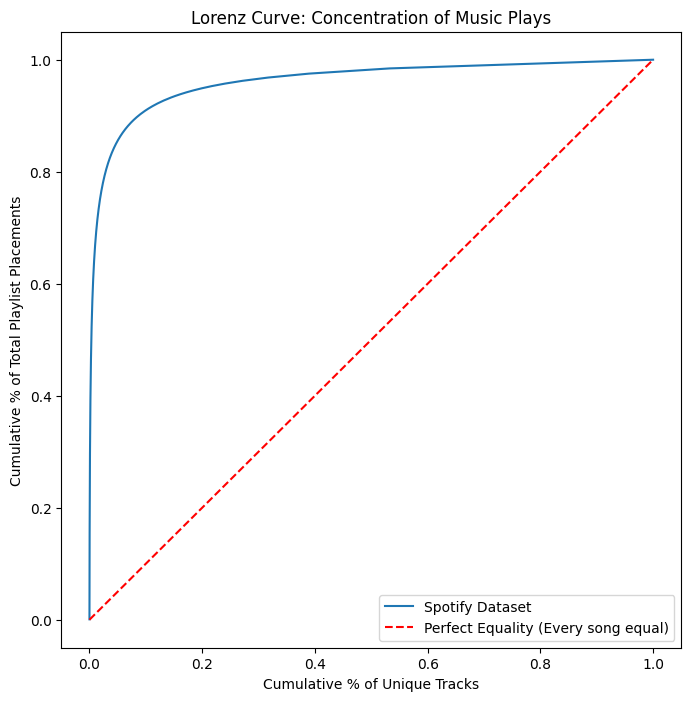

In [27]:
plt.figure(figsize=(8, 8))
plt.plot(np.linspace(0, 1, len(cum_percentage)), cum_percentage.get(), label='Spotify Dataset')
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Equality (Every song equal)')
plt.title("Lorenz Curve: Concentration of Music Plays")
plt.xlabel("Cumulative % of Unique Tracks")
plt.ylabel("Cumulative % of Total Playlist Placements")
plt.legend()
plt.show()

## Hypothesis 2. Popularity correlation - Positional Bias

We check it to weighten tracks, if the hypothesis is true

1. Steep downward slope for first 10 songs. Exponentil decay weightning is solution:
$$Value = 1.0 \times e^{-\lambda \cdot pos}$$


2.Mostly flat line. Position doesnt matter.

3. Albums ranker behavior


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Calculate Global Popularity (How many times each track appears in the whole dataset)
track_popularity = df_playlist['track_hash'].value_counts().reset_index()
track_popularity.columns = ['track_hash', 'global_count']

# 2. Join popularity back to the main table
# This adds a 'global_count' column next to every track instance
df_with_pop = df_playlist.merge(track_popularity, on='track_hash', how='left')

# 3. Filter for the "Head" of playlists (e.g., first 50 positions)
# This prevents extreme outliers from very long playlists from skewing the mean
df_head = df_with_pop[df_with_pop['pos'] <= 50]

# 4. Calculate the Mean Global Popularity for each position
# This is the "Magic Moment": it shows if position 0 is more 'popular' than position 40
positional_trend = df_head.groupby('pos')['global_count'].mean()

# 5. Plotting
plt.figure(figsize=(12, 6))
plt.plot(positional_trend.index, positional_trend.values, color='#1DB954', linewidth=2)
plt.fill_between(positional_trend.index, positional_trend.values, alpha=0.2, color='#1DB954')
plt.title("Is there a Positional Bias? (Avg Popularity vs. Playlist Position)")
plt.xlabel("Position in Playlist (0 = First Song)")
plt.ylabel("Average Global Popularity")
plt.xticks(range(0, 51, 5))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
from scipy.optimize import curve_fit

# 1. Take your EDA trend data
# x = positions (0, 1, 2...), y = mean global popularity
x_data = positional_trend.index.values
y_data = positional_trend.values

# 2. Normalize y_data so it starts at 1.0 (to match the e^-λx scale)
y_data_norm = y_data / y_data[0]

# 3. Define the decay function
def decay_func(x, lam):
    return np.exp(-lam * x)

# 4. Fit the curve to find the optimal lambda
popt, _ = curve_fit(decay_func, x_data, y_data_norm, p0=[0.05])
best_lam = popt[0]

print(f"The mathematically optimal lambda for your data is: {best_lam:.4f}")

## Hypothesis 3. Cohesion hypothesis

We check it, to understand whether we rely on CF or we prioritize album/artists

In [ ]:
# Calculate Artist Consistency per Playlist
# Using your flat (pid, track_hash) table
# 1. Join Artist IDs to your table
df_with_meta = df_playlist.merge(track_metadata[['track_hash', 'artist_name', 'album_name']], on='track_hash')

# 2. Group by PID and count unique artists vs total tracks
cohesion_stats = df_with_meta.groupby('pid').agg(
    unique_artists=('artist_id', 'nunique'),
    total_tracks=('track_hash', 'count'),
    top_artist_ratio=('artist_id', lambda x: x.value_counts().max() / len(x))
)

# 3. Insight: If top_artist_ratio is high (e.g. > 0.3), users are 'Artist-Loyal': rely on CF only if stats is low
print(cohesion_stats['top_artist_ratio'].mean())

## Hypothesis 4. Vocabulary hypothesis

We check it to use FAISS or not

In [ ]:
total_count = len(df)

# 1. Raw Uniqueness
raw_unique = df[title_col].nunique()

# 2. Cleaned Uniqueness (Normalization)
# We remove symbols, emojis, and lowercase everything
def clean_title(text):
    if not isinstance(text, str): return ""
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text) # Keep only alphanumeric
    return text.strip()

cleaned_series = df[title_col].apply(clean_title)
# Remove empty strings after cleaning (like playlists named '!!!')
cleaned_series = cleaned_series[cleaned_series != ""]

clean_unique = cleaned_series.nunique()

# 3. Calculate Results
print(f"--- Title Uniqueness Report ---")
print(f"Total Playlists:         {total_count:,}")
print(f"Raw Unique Titles:       {raw_unique:,}  ({(raw_unique/total_count)*100:.2f}%)")
print(f"Cleaned Unique Titles:   {clean_unique:,}  ({(clean_unique/total_count)*100:.2f}%)")

return cleaned_series.value_counts()
top_10 = top_titles.head(10)
print("Top 10 Cleaned Titles:\n", top_10)

## Hypothesis 5. Temporal flow



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Calculate the 'Library Standard Deviation' (The baseline)
library_std = df_tracks['duration_ms'].std()

# 2. Join durations to your flat playlist table (pid, track_hash)
df_with_dur = df.merge(df_tracks[['track_hash', 'duration_ms']], on='track_hash')

# 3. Calculate the 'Internal Standard Deviation' for every playlist
playlist_stats = df_with_dur.groupby('pid')['duration_ms'].agg(['mean', 'std', 'count'])

# 4. Filter out very short playlists (which have artificially low STD)
playlist_stats = playlist_stats[playlist_stats['count'] > 5]

# 5. Insight: If Avg(Internal STD) < Library STD, users care about pacing
print(f"Library Duration STD: {library_std:.2f}")
print(f"Avg Playlist Duration STD: {playlist_stats['std'].mean():.2f}")

## Title Embeddings



In [ ]:
from sentence_transformers import SentenceTransformer
import cupy as cp
import pandas as pd

# 1. Load the most popular industry model for short text
model = SentenceTransformer('all-MiniLM-L6-v2')
def get_context_vector(name):
    return nlp_model.encode([name])[0]
# 2. Extract your playlist titles
# Assuming your titles are in a list called 'playlist_titles'
df_playlist = pd.read_csv('/content/drive/My Drive/spotify-challenge/playlist_library.csv')
titles = df_playlist['p_name']

# 3. Generate Embeddings (Industry Practice: Use Batching)
# This turns text into a (1000000, 384) float matrix
title_embeddings = model.encode(titles, batch_size=128, show_progress_bar=True, convert_to_numpy=True)

# 4. Move to GPU for fast search later
title_embeddings_gpu = cp.array(title_embeddings)

# 5. Save to Drive (Checkpointing)
cp.save('/content/drive/My Drive/spotify-challenge/title_embeddings.npy', title_embeddings_gpu)

Do Sliding window algorithm

# Evaluation

In [ ]:
import pandas as pd
import numpy as np

def create_test_set(playlists_df, n_test=1000):
    # 1. Randomly sample 1000 playlists
    test_samples = playlists_df.sample(n_test)

    test_data = []
    for idx, row in test_samples.iterrows():
        all_tracks = row['track_ids']
        if len(all_tracks) < 10: continue # Skip tiny playlists

        # 2. Split: Use 5 tracks as "Input" and the rest as "Ground Truth"
        input_tracks = all_tracks[:5]
        hidden_tracks = all_tracks[5:]

        test_data.append({
            'title': row['title'],
            'input_tracks': input_tracks,
            'hidden_tracks': hidden_tracks
        })
    return test_data

# Usage
# my_test_set = create_test_set(original_data_df)

In [ ]:
def run_evaluation(test_set, faiss_index, model):
    total_recall = 0

    for case in test_set:
        # STEP A: Create Title Vector
        query_vec = model.encode([case['title']])
        faiss.normalize_L2(query_vec)

        # STEP B: Search for 100 Similar Playlists
        # This gives us a "Neighborhood"
        distances, neighbor_indices = faiss_index.search(query_vec, 100)

        # STEP C: Aggregation (The "Voting")
        # Count which songs appear most in those 100 playlists
        candidate_songs = []
        for n_idx in neighbor_indices[0]:
            candidate_songs.extend(get_songs_for_playlist(n_idx))

        # Get the Top 500 most frequent songs
        from collections import Counter
        top_500_recs = [song for song, count in Counter(candidate_songs).most_common(500)]

        # STEP D: Calculate Hit Rate
        hits = len(set(top_500_recs).intersection(set(case['hidden_tracks'])))
        recall = hits / len(case['hidden_tracks'])
        total_recall += recall

    avg_recall = total_recall / len(test_set)
    print(f"Average Recall@500 for Title-Only: {avg_recall:.2%}")